<a href="https://colab.research.google.com/github/kashishkhera44/comp215/blob/main/labs/lab10_wealth_inequality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 10: Wealth Inequality

This lab uses the Sugarscape model to explore possible mechanisms to reduce wealth inequality in society.   The bulk of this lab is implementing the Sugarscape model given in the textbook.  The exercise for you to complete is at the bottom of this worksheet.

This is based heavily on code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com)] Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT).  



### Imports

In [1]:
!pip install empiricaldist
from empiricaldist import Cdf, Pmf

import os
if not os.path.exists('utils.py'):
    !wget https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/utils.py
if not os.path.exists('Cell2D.py'):
    !wget https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/Cell2D.py


%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from utils import decorate

from scipy.signal import correlate2d
from Cell2D import Cell2D, draw_array

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.8.0-py3-none-any.whl size=12586 sha256=81057dfda951e46c2cdc6346d6c2b8b133d403148bb3de0468cff7230ae74896
  Stored in directory: /root/.cache/pip/wheels/ca/a9/1f/90c7a8a37ac37ff0fa0a27b2152f9b24be8910448ab93992f8
Successfully built empiricaldist
--2025-03-31 06:43:59--  https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2645 (2.6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.58K  --.-KB/s    in 0s      

2025-03-31 06:44:00 (37.4 MB/s) - ‘uti

### Define Some Helper Functions

`make_locs` takes the dimensions of the grid and returns an array where each row is a coordinate in the grid.

In [2]:
def make_locs(n, m):
    """Makes array where each row is an index in an `n` by `m` grid.

    n: int number of rows
    m: int number of cols

    returns: NumPy array
    """
    t = [(i, j) for i in range(n) for j in range(m)]
    return np.array(t)

In [3]:
make_locs(2, 3)

array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2]])

`make_visible_locs` takes the range of an agents vision and returns an array where each row is the coordinate of a visible cell.  The cells are at increasing distances.  The cells at each distance are shuffled to randomize the agents choice.

In [4]:
def make_visible_locs(vision):
    """Computes the kernel of visible cells.

    vision: int distance
    """
    def make_array(d):
        """Generates visible cells with increasing distance."""
        a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
        np.random.shuffle(a)
        return a

    arrays = [make_array(d) for d in range(1, vision+1)]
    return np.vstack(arrays)

In [5]:
make_visible_locs(1)

array([[-1,  0],
       [ 0, -1],
       [ 0,  1],
       [ 1,  0]])

`distances_from` returns an array that contains the distance of each cell from the given coordinates.

In [6]:
def distances_from(n, i, j):
    """Computes an array of distances.

    n: size of the array
    i, j: coordinates to find distance from

    returns: array of float
    """
    X, Y = np.indices((n, n))
    return np.hypot(X-i, Y-j)

In [7]:
dist = distances_from(5, 2, 2)
dist

array([[2.82842712, 2.23606798, 2.        , 2.23606798, 2.82842712],
       [2.23606798, 1.41421356, 1.        , 1.41421356, 2.23606798],
       [2.        , 1.        , 0.        , 1.        , 2.        ],
       [2.23606798, 1.41421356, 1.        , 1.41421356, 2.23606798],
       [2.82842712, 2.23606798, 2.        , 2.23606798, 2.82842712]])

I use `np.digitize` to set the capacity in each cell according to the distance from the peak.  Here's an example that shows how it works.

In [8]:
bins = [3, 2, 1, 0]
np.digitize(dist, bins)

array([[1, 1, 1, 1, 1],
       [1, 2, 2, 2, 1],
       [1, 2, 3, 2, 1],
       [1, 2, 2, 2, 1],
       [1, 1, 1, 1, 1]])

Here's my implementation of Sugarscape:

In [9]:
class Sugarscape(Cell2D):
    """Represents an Epstein-Axtell Sugarscape."""

    def __init__(self, n, **params):
        """Initializes the attributes.

        n: number of rows and columns
        params: dictionary of parameters
        """
        self.n = n
        self.params = params

        # track variables
        self.agent_count_seq = []

        # make the capacity array
        self.capacity = self.make_capacity()

        # initially all cells are at capacity
        self.array = self.capacity.copy()

        # make the agents
        self.make_agents()

    def make_capacity(self):
        """Makes the capacity array."""

        # compute the distance of each cell from the peaks.
        dist1 = distances_from(self.n, 15, 15)
        dist2 = distances_from(self.n, 35, 35)
        dist = np.minimum(dist1, dist2)

        # cells in the capacity array are set according to dist from peak
        bins = [21, 16, 11, 6]
        a = np.digitize(dist, bins)
        return a

    def make_agents(self):
        """Makes the agents."""

        # determine where the agents start and generate locations
        n, m = self.params.get('starting_box', self.array.shape)
        locs = make_locs(n, m)
        np.random.shuffle(locs)

        # make the agents
        num_agents = self.params.get('num_agents', 400)
        assert(num_agents <= len(locs))
        self.agents = [Agent(locs[i], self.params)
                       for i in range(num_agents)]

        # keep track of which cells are occupied
        self.occupied = set(agent.loc for agent in self.agents)

    def grow(self):
        """Adds sugar to all cells and caps them by capacity."""
        grow_rate = self.params.get('grow_rate', 1)
        self.array = np.minimum(self.array + grow_rate, self.capacity)

    def look_and_move(self, center, vision):
        """Finds the visible cell with the most sugar.

        center: tuple, coordinates of the center cell
        vision: int, maximum visible distance

        returns: tuple, coordinates of best cell
        """
        # find all visible cells
        locs = make_visible_locs(vision)
        locs = (locs + center) % self.n

        # convert rows of the array to tuples
        locs = [tuple(loc) for loc in locs]

        # select unoccupied cells
        empty_locs = [loc for loc in locs if loc not in self.occupied]

        # if all visible cells are occupied, stay put
        if len(empty_locs) == 0:
            return center

        # look up the sugar level in each cell
        t = [self.array[loc] for loc in empty_locs]

        # find the best one and return it
        # (in case of tie, argmax returns the first, which
        # is the closest)
        i = np.argmax(t)
        return empty_locs[i]

    def harvest(self, loc):
        """Removes and returns the sugar from `loc`.

        loc: tuple coordinates
        """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar

    def step(self):
        """Executes one time step."""
        replace = self.params.get('replace', False)

        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        for agent in random_order:

            # mark the current cell unoccupied
            self.occupied.remove(agent.loc)

            # execute one step
            agent.step(self)

            # if the agent is dead, remove from the list
            if agent.is_starving() or agent.is_old():
                self.agents.remove(agent)
                if replace:
                    self.add_agent()
            else:
                # otherwise mark its cell occupied
                self.occupied.add(agent.loc)

        # update the time series
        self.agent_count_seq.append(len(self.agents))

        # grow back some sugar
        self.grow()
        return len(self.agents)

    def add_agent(self):
        """Generates a new random agent.

        returns: new Agent
        """
        new_agent = Agent(self.random_loc(), self.params)
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent

    def random_loc(self):
        """Choose a random unoccupied cell.

        returns: tuple coordinates
        """
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc

    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='YlOrRd', vmax=9, origin='lower')

        # draw the agents
        xs, ys = self.get_coords()
        self.points = plt.plot(xs, ys, '.', color='red')[0]

    def get_coords(self):
        """Gets the coordinates of the agents.

        Transforms from (row, col) to (x, y).

        returns: tuple of sequences, (xs, ys)
        """
        agents = self.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

Here's my implementation of the agents.

In [10]:
class Agent:

    def __init__(self, loc, params):
        """Creates a new agent at the given location.

        loc: tuple coordinates
        params: dictionary of parameters
        """
        self.loc = tuple(loc)
        self.age = 0

        # extract the parameters
        max_vision = params.get('max_vision', 6)
        max_metabolism = params.get('max_metabolism', 4)
        min_lifespan = params.get('min_lifespan', 10000)
        max_lifespan = params.get('max_lifespan', 10000)
        min_sugar = params.get('min_sugar', 5)
        max_sugar = params.get('max_sugar', 25)

        # choose attributes
        self.vision = np.random.randint(1, max_vision+1)
        self.metabolism = np.random.uniform(1, max_metabolism)
        self.lifespan = np.random.uniform(min_lifespan, max_lifespan)
        self.sugar = np.random.uniform(min_sugar, max_sugar)

    def step(self, env):
        """Look around, move, and harvest.

        env: Sugarscape
        """
        self.loc = env.look_and_move(self.loc, self.vision)
        self.sugar += env.harvest(self.loc) - self.metabolism
        self.age += 1

    def is_starving(self):
        """Checks if sugar has gone negative."""
        return self.sugar < 0

    def is_old(self):
        """Checks if lifespan is exceeded."""
        return self.age > self.lifespan

Here's an example with `n=50`, starting with 400 agents.

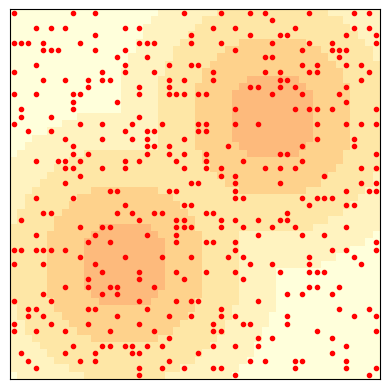

In [11]:
env = Sugarscape(50, num_agents=400)
env.draw()

Plot the distribution of sugar, metabolism, and vision for the initial condiguration.

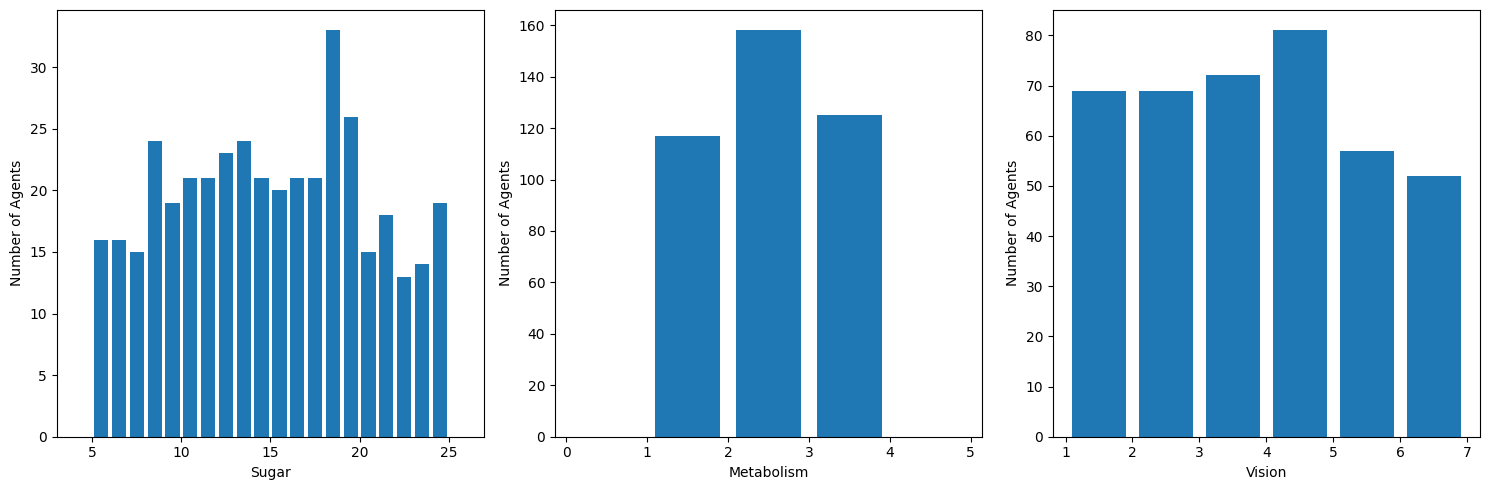

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
axs[0].hist([agent.sugar for agent in env.agents], bins=range(4,27), rwidth=0.8)
axs[0].set_xlabel('Sugar')
axs[0].set_ylabel('Number of Agents')
axs[1].hist([agent.metabolism for agent in env.agents], bins=range(0,6), rwidth=0.8)
axs[1].set_xlabel('Metabolism')
axs[1].set_ylabel('Number of Agents')
axs[2].hist([agent.vision for agent in env.agents], bins=range(1,8), rwidth=0.8)
axs[2].set_xlabel('Vision')
axs[2].set_ylabel('Number of Agents')

plt.show()

And now see the same properties through the cummulative distribution functions.  

The distribution of vision is uniform from 1 to 6.

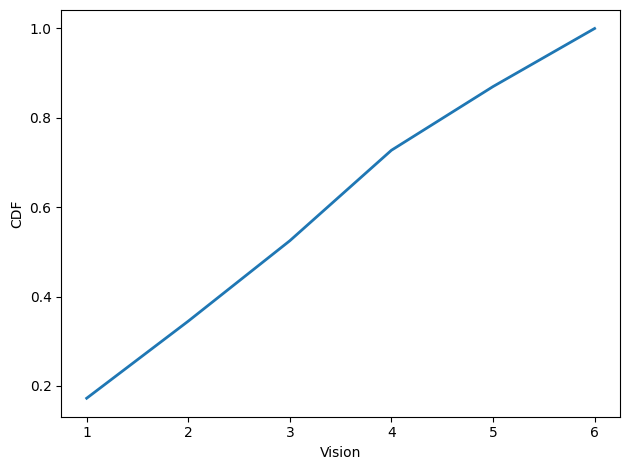

In [13]:
cdf = Cdf.from_seq(agent.vision for agent in env.agents)
cdf.plot()
decorate(xlabel='Vision', ylabel='CDF')

The distribution of metabolism is uniform from 1 to 4.

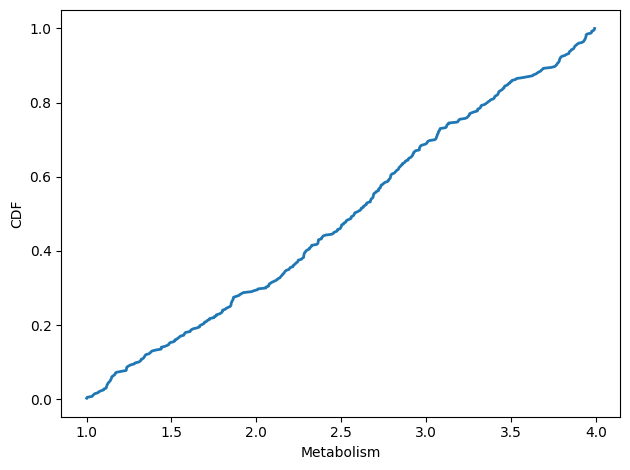

In [14]:
cdf = Cdf.from_seq(agent.metabolism for agent in env.agents)
cdf.plot()
decorate(xlabel='Metabolism', ylabel='CDF')

The distribution of initial endowment of sugar is uniform from 5 to 25.

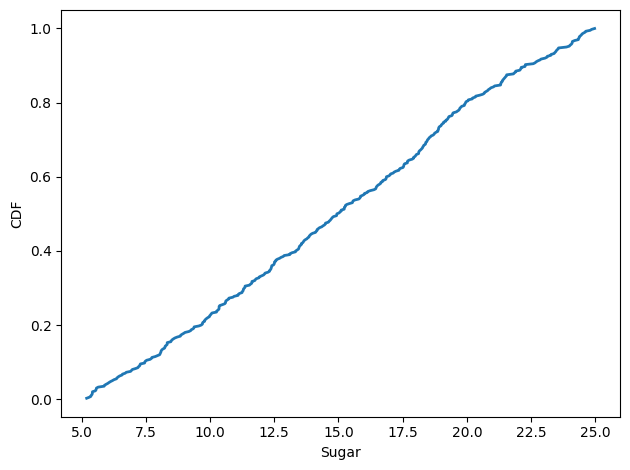

In [15]:
cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
cdf.plot()
decorate(xlabel='Sugar', ylabel='CDF')

Test a single step.

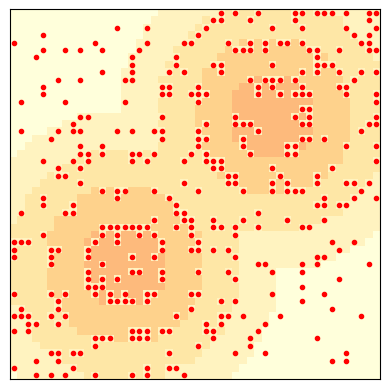

In [16]:
env.step()
env.draw()

Here's what the animation looks like.

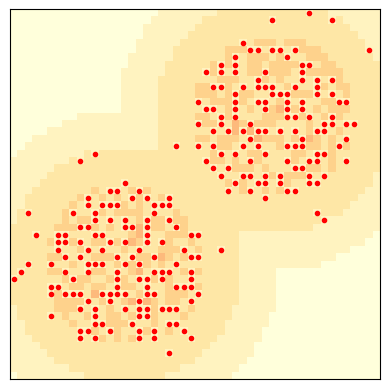

In [17]:
env.animate(frames=50)

The number of agents levels off at the "carrying capacity":

In [18]:
len(env.agents)

256

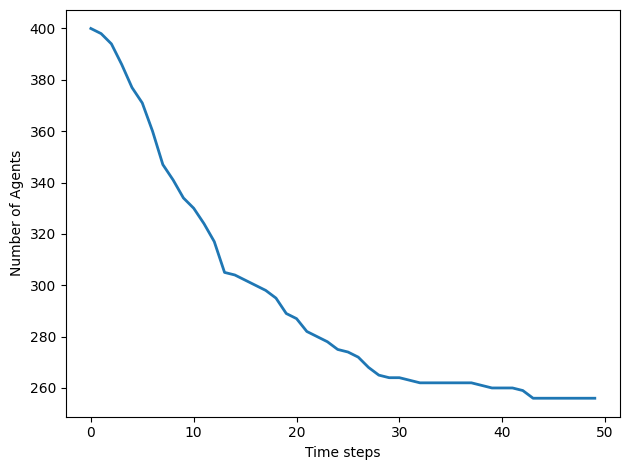

In [19]:
plt.plot(env.agent_count_seq)
decorate(xlabel='Time steps', ylabel='Number of Agents')

This figure shows the state of the system after 2 and 10 steps.

In [20]:
env = Sugarscape(50, num_agents=400)
three_frame(env, [0, 2, 98])

plt.show('figs/chap10-3')

NameError: name 'three_frame' is not defined

## Sugarscape with finite lifespans

Now we start with 250 agents, with lifetimes from 60 to 100, and replacement.

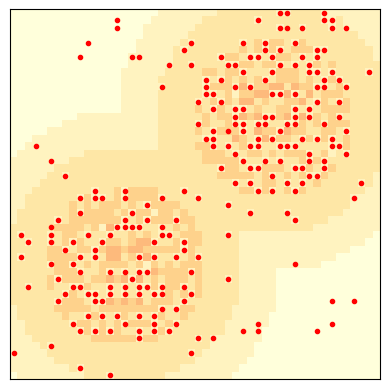

In [21]:
env = Sugarscape(50, num_agents=250,
                 min_lifespan=60, max_lifespan=100,
                 replace=True)

env.animate(frames=100)

After 100 time steps, the distribution of wealth is skewed to the right.  Most agents have very little sugar, but a few have a lot.

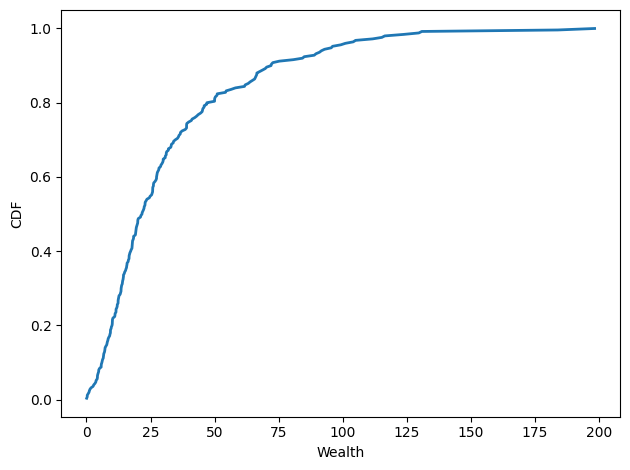

In [22]:
cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
cdf.plot()
decorate(xlabel='Wealth', ylabel='CDF')

In [23]:
cdf.quantile([0.25, 0.50, 0.75, 0.90])

array([11.99495736, 21.65519568, 40.90552651, 72.01870251])

Starting with the same parameters, I'll run the model 500 steps, recording the distribution of wealth after each 100 steps:

In [24]:
np.random.seed(17)

env = Sugarscape(50, num_agents=250,
                 min_lifespan=60, max_lifespan=100,
                 replace=True)

cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
cdfs = [cdf]
for i in range(5):
    env.loop(100)
    cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
    cdfs.append(cdf)

After about 200 steps, the distribution is stationary (doesn't change over time).

On a log scale, it is approximately normal, possibly with a truncated right tail.

In [28]:
class Sugarscape(Cell2D):

    def step(self):
        """Executes one time step with wealth redistribution."""
        replace = self.params.get('replace', False)
        tax_threshold = self.params.get('tax_threshold', 50)  # Wealth above which tax is applied
        tax_rate = self.params.get('tax_rate', 0.1)  # Percentage of wealth taxed
        welfare_threshold = self.params.get('welfare_threshold', 10)  # Wealth below which welfare is given
        welfare_amount = self.params.get('welfare_amount', 5)  # Amount of welfare provided

        welfare_pool = 0  # Initialize welfare pool

        random_order = np.random.permutation(self.agents)
        for agent in random_order:
            self.occupied.remove(agent.loc)
            agent.step(self)

            # Wealth Redistribution
            if agent.sugar > tax_threshold:
                tax = int(agent.sugar * tax_rate)  # Calculate tax
                agent.sugar -= tax  # Deduct tax from agent's wealth
                welfare_pool += tax  # Add tax to welfare pool

            if agent.sugar < welfare_threshold:
                agent.sugar += welfare_amount  # Provide welfare to agent
                welfare_pool -= welfare_amount  # Deduct welfare from pool

            if agent.is_starving() or agent.is_old():
                self.agents.remove(agent)
                if replace:
                    self.add_agent()
            else:
                self.occupied.add(agent.loc)

        self.agent_count_seq.append(len(self.agents))
        self.grow()
        return len(self.agents)


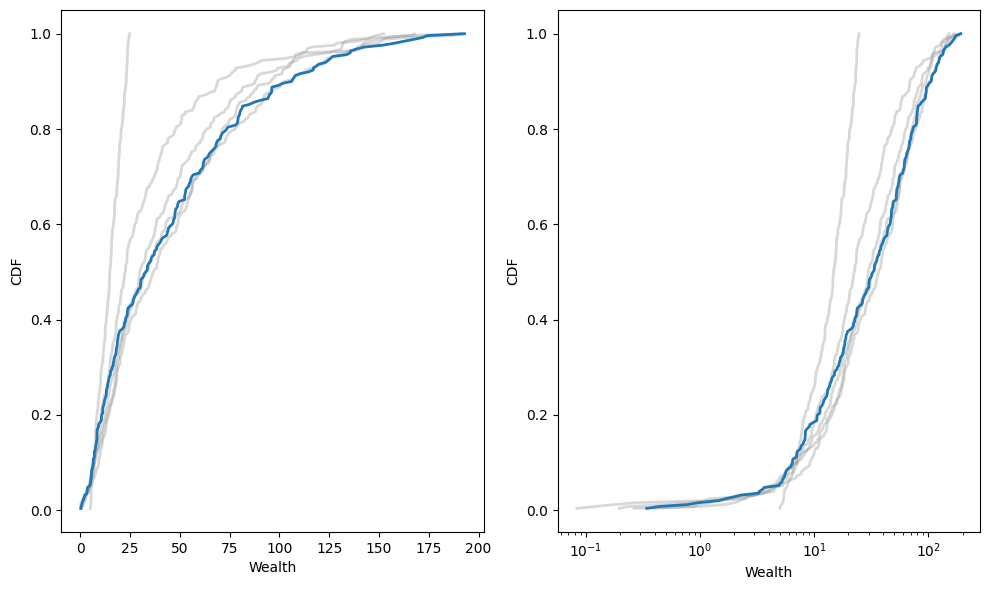

In [25]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)

def plot_cdfs(cdfs, **options):
    for cdf in cdfs:
        cdf.plot(**options)

plot_cdfs(cdfs[:-1], color='gray', alpha=0.3)
plot_cdfs(cdfs[-1:], color='C0')
decorate(xlabel='Wealth', ylabel='CDF')

plt.subplot(1, 2, 2)
plot_cdfs(cdfs[:-1], color='gray', alpha=0.3)
plot_cdfs(cdfs[-1:], color='C0')
decorate(xlabel='Wealth', ylabel='CDF', xscale='log')

plt.show('figs/chap10-4')

**Exercise:** Implement a version of the Sugarscape class that contains some mechanism for wealth redistribution.  You could create a 'tax' on the wealthy that simply removes the some amount of wealth above some threshold.  You could create a 'tax' that removes some amount of wealth from the wealthy and gives it to the poor. You can think of your own way to redistribute wealth in this model.   

What effect do your changes have on the distribution of wealth?

In [45]:
from IPython import get_ipython
from IPython.display import display
# %% [markdown]
# # Lab 10: Wealth Inequality
#
# This lab uses the Sugarscape model to explore possible mechanisms to reduce wealth inequality in society.   The bulk of this lab is implementing the Sugarscape model given in the textbook.  The exercise for you to complete is at the bottom of this worksheet.
#
# This is based heavily on code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com)] Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT).
#
#
# %% [markdown]
# ### Imports
# %%
!pip install empiricaldist
from empiricaldist import Cdf, Pmf

import os
if not os.path.exists('utils.py'):
    !wget https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/utils.py
if not os.path.exists('Cell2D.py'):
    !wget https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/Cell2D.py


%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from utils import decorate

from scipy.signal import correlate2d
from Cell2D import Cell2D, draw_array
# %% [markdown]
# ### Define Some Helper Functions
# %% [markdown]
# `make_locs` takes the dimensions of the grid and returns an array where each row is a coordinate in the grid.
# %%
def make_locs(n, m):
    """Makes array where each row is an index in an `n` by `m` grid.

    n: int number of rows
    m: int number of cols

    returns: NumPy array
    """
    t = [(i, j) for i in range(n) for j in range(m)]
    return np.array(t)
# %%
make_locs(2, 3)
# %% [markdown]
# `make_visible_locs` takes the range of an agents vision and returns an array where each row is the coordinate of a visible cell.  The cells are at increasing distances.  The cells at each distance are shuffled to randomize the agents choice.
# %%
def make_visible_locs(vision):
    """Computes the kernel of visible cells.

    vision: int distance
    """
    def make_array(d):
        """Generates visible cells with increasing distance."""
        a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
        np.random.shuffle(a)
        return a

    arrays = [make_array(d) for d in range(1, vision+1)]
    return np.vstack(arrays)
# %%
make_visible_locs(1)
# %% [markdown]
# `distances_from` returns an array that contains the distance of each cell from the given coordinates.
# %%
def distances_from(n, i, j):
    """Computes an array of distances.

    n: size of the array
    i, j: coordinates to find distance from

    returns: array of float
    """
    X, Y = np.indices((n, n))
    return np.hypot(X-i, Y-j)
# %%
dist = distances_from(5, 2, 2)
dist
# %% [markdown]
# I use `np.digitize` to set the capacity in each cell according to the distance from the peak.  Here's an example that shows how it works.
# %%
bins = [3, 2, 1, 0]
np.digitize(dist, bins)
# %% [markdown]
# Here's my implementation of Sugarscape:
# %%
class Sugarscape(Cell2D):
    """Represents an Epstein-Axtell Sugarscape."""

    def __init__(self, n, **params):
        """Initializes the attributes.

        n: number of rows and columns
        params: dictionary of parameters
        """
        # Call the parent class's __init__ method with appropriate arguments
        # Here, we pass 'n' as the size of the grid
        super().__init__(n)

        # Initialize Sugarscape-specific attributes
        self.n = n
        self.params = params
        self.agent_count_seq = []
        self.tax_threshold = params.get('tax_threshold', 50)  # Wealth above which tax is applied
        self.tax_rate = params.get('tax_rate', 0.1)  # Percentage of wealth taxed
        self.welfare_threshold = params.get('welfare_threshold', 10)  # Wealth below which welfare is given
        self.welfare_amount = params.get('welfare_amount', 5)  # Amount of welfare provided
        self.capacity = self.make_capacity()
        self.array = self.capacity.copy()
        self.make_agents()

    def make_capacity(self):
        """Makes the capacity array."""

        # compute the distance of each cell from the peaks.
        dist1 = distances_from(self.n, 15, 15)
        dist2 = distances_from(self.n, 35, 35)
        dist = np.minimum(dist1, dist2)

        # cells in the capacity array are set according to dist from peak
        bins = [21, 16, 11, 6]
        a = np.digitize(dist, bins)
        return a

    def make_agents(self):
        """Makes the agents."""

        # determine where the agents start and generate locations
        n, m = self.params.get('starting_box', self.array.shape)
        locs = make_locs(n, m)
        np.random.shuffle(locs)

        # make the agents
        num_agents = self.params.get('num_agents', 400)
        assert(num_agents <= len(locs))
        self.agents = [Agent(locs[i], self.params)
                       for i in range(num_agents)]

        # keep track of which cells are occupied
        self.occupied = set(agent.loc for agent in self.agents)

    def grow(self):
        """Adds sugar to all cells and caps them by capacity."""
        grow_rate = self.params.get('grow_rate', 1)
        self.array = np.minimum(self.array + grow_rate, self.capacity)

    def look_and_move(self, center, vision):
        """Finds the visible cell with the most sugar.

        center: tuple, coordinates of the center cell
        vision: int, maximum visible distance

        returns: tuple, coordinates of best cell
        """
        # find all visible cells
        locs = make_visible_locs(vision)
        locs = (locs + center) % self.n

        # convert rows of the array to tuples
        locs = [tuple(loc) for loc in locs]

        # select unoccupied cells
        empty_locs = [loc for loc in locs if loc not in self.occupied]

        # if all visible cells are occupied, stay put
        if len(empty_locs) == 0:
            return center

        # look up the sugar level in each cell
        t = [self.array[loc] for loc in empty_locs]

        # find the best one and return it
        # (in case of tie, argmax returns the first, which
        # is the closest)
        i = np.argmax(t)
        return empty_locs[i]

    def harvest(self, loc):
        """Removes and returns the sugar from `loc`.

        loc: tuple coordinates
        """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar

    def step(self):
        """Executes one time step."""
        replace = self.params.get('replace', False)

        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)

        # Initialize welfare pool for this step
        welfare_pool = 0

        for agent in random_order:
            # mark the current cell unoccupied
            self.occupied.remove(agent.loc)

            # execute one step
            agent.step(self)

            # Wealth Redistribution:
            # Tax agents above the threshold and add to the welfare pool
            if agent.sugar > self.tax_threshold:
                tax = int(agent.sugar * self.tax_rate)
                agent.sugar -= tax
                welfare_pool += tax

            # Provide welfare to agents below the threshold
            if agent.sugar < self.welfare_threshold:
                agent.sugar += self.welfare_amount
                welfare_pool -= self.welfare_amount  # Deduct from the pool

            # if the agent is dead, remove from the list
            if agent.is_starving() or agent.is_old():
                self.agents.remove(agent)
                if replace:
                    self.add_agent()
            else:
                # otherwise mark its cell occupied
                self.occupied.add(agent.loc)

        # update the time series
        self.agent_count_seq.append(len(self.agents))

        # grow back some sugar
        self.grow()
        return len(self.agents)

    def add_agent(self):
        """Generates a new random agent.

        returns: new Agent
        """
        new_agent = Agent(self.random_loc(), self.params)
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent

    def random_loc(self):
        """Choose a random unoccupied cell.

        returns: tuple coordinates
        """
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc

    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='YlOrRd', vmax=9, origin='lower')

        # draw the agents
        xs, ys = self.get_coords()
        self.points = plt.plot(xs, ys, '.', color='red')[0]

    def get_coords(self):
        """Gets the coordinates of the agents.

        Transforms from (row, col) to (x, y).

        returns: tuple of sequences, (xs, ys)
        """
        agents = self.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

In [36]:

class Sugarscape(Cell2D):
    """Represents an Epstein-Axtell Sugarscape."""

    def __init__(self, n, **params):
        """Initializes the attributes.

        n: number of rows and columns
        params: dictionary of parameters
        """
        # Call the parent class's __init__ method with appropriate arguments
        # Here, we pass 'n' as the size of the grid
        super().__init__(n)

        # Initialize Sugarscape-specific attributes
        self.n = n
        self.params = params
        self.agent_count_seq = []
        self.tax_threshold = params.get('tax_threshold', 50)  # Wealth above which tax is applied
        self.tax_rate = params.get('tax_rate', 0.1)  # Percentage of wealth taxed
        self.welfare_threshold = params.get('welfare_threshold', 10)  # Wealth below which welfare is given
        self.welfare_amount = params.get('welfare_amount', 5)  # Amount of welfare provided
        self.capacity = self.make_capacity()
        self.array = self.capacity.copy()
        self.make_agents()

    def make_capacity(self):
        """Makes the capacity array."""

        # compute the distance of each cell from the peaks.
        dist1 = distances_from(self.n, 15, 15)
        dist2 = distances_from(self.n, 35, 35)
        dist = np.minimum(dist1, dist2)

        # cells in the capacity array are set according to dist from peak
        bins = [21, 16, 11, 6]
        a = np.digitize(dist, bins)
        return a


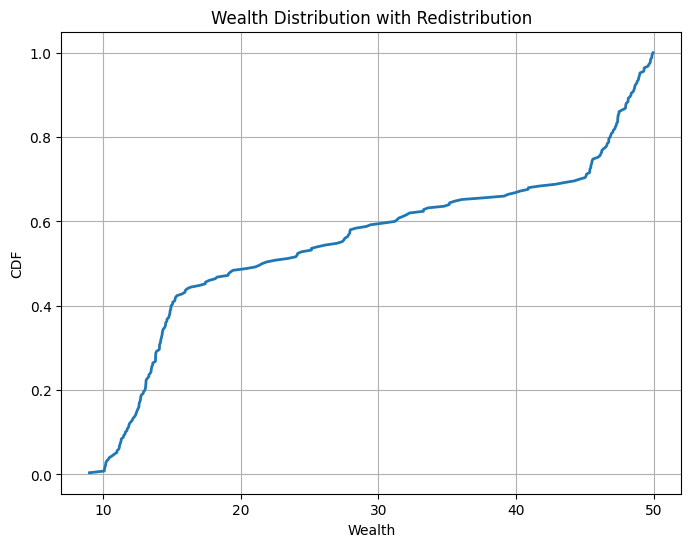

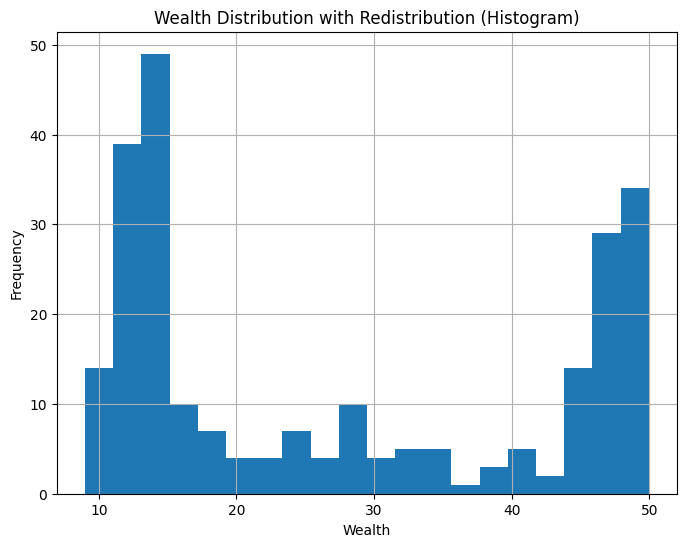

In [48]:


# Create a Sugarscape environment with wealth redistribution
env = Sugarscape(50, num_agents=250, min_lifespan=60,
                 max_lifespan=100, replace=True,
                 tax_threshold=50, tax_rate=0.1,
                 welfare_threshold=10, welfare_amount=5)

# Run the simulation for a certain number of steps (e.g., 500)
env.loop(500)

# Get the wealth of all agents
wealth = [agent.sugar for agent in env.agents]

# Create a CDF of the wealth distribution
cdf = Cdf.from_seq(wealth)

# Plot the CDF
plt.figure(figsize=(8, 6))
cdf.plot()
plt.title('Wealth Distribution with Redistribution')
plt.xlabel('Wealth')
plt.ylabel('CDF')
plt.grid(True)
plt.show()

# Optionally, you can also create a histogram of the wealth distribution:
plt.figure(figsize=(8, 6))
plt.hist(wealth, bins=20)
plt.title('Wealth Distribution with Redistribution (Histogram)')
plt.xlabel('Wealth')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()